In [1]:
import numpy as np
import io

import matplotlib.pyplot as plt

import sys
import os

# Assuming /AutomationModule is in the root directory of your project
sys.path.append(os.path.abspath(r'H:\phd stuff\tidy3d'))

from AutomationModule import * 

import AutomationModule as AM

In [2]:
file_path = r"H:\phd stuff\tidy3d\structures\End2EndFiles\filtered\lsu_0p8_filter.txt"

In [3]:
def create_permittivity_grid_penlike(
    rod_endpoints,
    grid_size=128,
    minor_radius=0.1,        # circular radius in the pre-warp space (becomes ellipse after z-warp)
    aspect_ratio=None,        # global z scale factor s; ellipses have major/minor = s (projected)
    aspect_ratio_hole=None,        # global z scale factor s; ellipses have major/minor = s (projected)
    permittivity=3.42**2, #Si
    hole_minor_radius=0.0,   # inner circular radius in pre-warp space (same eccentricity after warp)
    box_size=14.3,
    *,
    progress_every=20,
    dinamic_radius=False,
    sigma_inner=None,
    sigma_outer=None,
    mean_inner=None,
    mean_outer=None,
    create_hole=False,
    use_radius_array=False,
    b_list=None

):
    """
    Build hollow 'pen-like' rods by:
      (1) creating RIGHT CIRCULAR cylinders in an unwarped space (x, y, z'),
      (2) applying a GLOBAL z warp: z = s * z'.

    IMPORTANT:
      - 'rod_endpoints' are given in FINAL (post-warp) world coords.
      - We unwarp them internally: z' = z / s.
      - Because the warp is GLOBAL, both shell and hole share the SAME ellipticity.
        You can set different radii (thickness), but not different ellipse ARs.

    Geometry:
      - Axis unit vector and clamping 0<=t<=L are computed in UNWARPED space.
      - Membership test is purely circular in UNWARPED cross-sections.
      - All ellipses are aligned with the projection of +z into each rod cross-plane.
        For rods parallel to z, the cross-section remains circular (expected).

    Returns:
      grid: (G,G,G) float32 array, ones background with 'permittivity' written inside rods.
    """
    rods = np.asarray(rod_endpoints, dtype=np.float32)/0.8  # scale to match original design
    G = int(grid_size)
    grid = np.ones((G, G, G), dtype=np.float32)

    dx = float(box_size) / G
    
    grid_coords = (np.arange(G, dtype=np.float32) + 0.5) * dx - np.float32(box_size / 2.0)

    # ----- radii setup (ensure arrays always exist) -----
    if not dinamic_radius:
        b_array  = np.full(len(rods), float(minor_radius), dtype=np.float32)
        b_h_array = np.full(len(rods), float(hole_minor_radius), dtype=np.float32)
    elif use_radius_array:
        if b_list is None:
            raise ValueError("b_list must be provided when use_radius_array=True.")
        if len(b_list) != len(rods):
            raise ValueError("b_list must have the same length as rod_endpoints.")
        b_array  = np.asarray(b_list, dtype=np.float32)
        b_h_array = np.random.normal(loc=mean_inner, scale=sigma_inner, size=len(rods)).astype(np.float32)
    else:
        b_array  = np.random.normal(loc=mean_outer, scale=sigma_outer, size=len(rods)).astype(np.float32)
        b_h_array = np.random.normal(loc=mean_inner, scale=sigma_inner, size=len(rods)).astype(np.float32)

    s = float(aspect_ratio) if aspect_ratio is not None else 1.0
    s_in = float(aspect_ratio_hole) if aspect_ratio_hole is not None else 1.0
    k_in  = s / s_in  # inner boundary z' scaling in UNWARPED space

    def idx_range_for_world(min_w, max_w, pad):
        lo = min_w - pad; hi = max_w + pad
        i0 = int(np.searchsorted(grid_coords, lo, side='left'))
        i1 = int(np.searchsorted(grid_coords, hi, side='right') - 1)
        i0 = max(i0, 0); i1 = min(i1, G - 1)
        if i1 < i0:
            mid = 0.5 * (min_w + max_w)
            i0 = i1 = max(min(int(np.searchsorted(grid_coords, mid, side='left')), G - 1), 0)
        return i0, i1

    for i_rod, rod in enumerate(rods):
        if progress_every and (i_rod % progress_every == 0):
            print(f"[postwarp] rod {i_rod} / {len(rods)}")

        b = b_array[i_rod]
        b_h = b_h_array[i_rod]
            
        use_hole = (b_h > 0.0) and (b_h < b)
        
        # pad in WORLD space: radius along directions with z-component can grow by up to s
        r_pad_world = b * max(1.0, s) + dx
        # FINAL (world) endpoints
        p1w = rod[:3].astype(np.float32)
        p2w = rod[3:].astype(np.float32)

        # UNWARP endpoints (z' = z / s) to build circular cylinder there
        p1u = p1w.copy(); p1u[2] = p1w[2] / s
        p2u = p2w.copy(); p2u[2] = p2w[2] / s

        vu = p2u - p1u
        L2u = float(np.dot(vu, vu))
        if L2u <= 0.0:
            continue
        Lu = float(np.sqrt(L2u))
        nu = vu / Lu  # axis in UNWARPED space

        # WORLD AABB expanded
        xmin, xmax = float(min(p1w[0], p2w[0])), float(max(p1w[0], p2w[0]))
        ymin, ymax = float(min(p1w[1], p2w[1])), float(max(p1w[1], p2w[1]))
        zmin, zmax = float(min(p1w[2], p2w[2])), float(max(p1w[2], p2w[2]))
        ix0, ix1 = idx_range_for_world(xmin, xmax, r_pad_world)
        iy0, iy1 = idx_range_for_world(ymin, ymax, r_pad_world)
        iz0, iz1 = idx_range_for_world(zmin, zmax, r_pad_world)

        xs = grid_coords[ix0:ix1+1]
        ys = grid_coords[iy0:iy1+1]
        zs = grid_coords[iz0:iz1+1]
        X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')

        # Map WORLD coords to UNWARPED coords (x, y, z') with z' = z / s
        Zu = Z / s

        # Vector from p1 in UNWARPED space
        RXu = X - p1u[0]
        RYu = Y - p1u[1]
        RZu = Zu - p1u[2]

        # Axial coordinate and clamping in UNWARPED space
        tu = RXu * nu[0] + RYu * nu[1] + RZu * nu[2]
        mask_len = (tu >= 0.0) & (tu <= Lu)

        # Perpendicular distance in UNWARPED space (circular test)
        rX = RXu - tu * nu[0]
        rY = RYu - tu * nu[1]
        rZ = RZu - tu * nu[2]


        r2 = rX**2 + rY**2 + rZ**2
        outer_ok = r2 <= (b**2)


        if use_hole and create_hole:
            r2_inner = rX**2 + rY**2 + (k_in * rZ)**2
            inner_ok = r2_inner <= (b_h**2)
            final_mask = mask_len & outer_ok & (~inner_ok)
        else:
            final_mask = mask_len & outer_ok

        if np.any(final_mask):
            sub = grid[ix0:ix1+1, iy0:iy1+1, iz0:iz1+1]
            sub[final_mask] = permittivity
            grid[ix0:ix1+1, iy0:iy1+1, iz0:iz1+1] = sub

    return grid,b_array


In [4]:
# import numpy as np

# def create_permittivity_grid_penlike(
#     rod_endpoints,
#     grid_size=128,
#     minor_radius=0.1,        # circular radius in the pre-warp space (becomes ellipse after z-warp)
#     aspect_ratio=None,        # global z scale factor s; ellipses have major/minor = s (projected)
#     aspect_ratio_hole=None,   # z scale for hole (lets inner/outer have different AR along z only)
#     permittivity=3.42**2,     # Si
#     hole_minor_radius=0.0,    # inner circular radius in pre-warp space
#     box_size=14.3,
#     *,
#     progress_every=20,
#     dinamic_radius=False,
#     sigma_inner=None,
#     sigma_outer=None,
#     mean_inner=None,
#     mean_outer=None,
#     create_hole=True,
#     use_radius_array=False,
#     b_list=None,
#     # --- NEW: pyramid (rectangular frustum) that SHORTENS rods (no voxel mask) ---
#     pyramid_enable=True,
#     pyramid_top_scale=0.85,       # <1.0 → narrower at z=+box/2 (X)
#     pyramid_bottom_scale=1.00,    # at z=-box/2 (X)
#     pyramid_top_scale_y=None,     # (optional) Y top; defaults to pyramid_top_scale
#     pyramid_bottom_scale_y=None,  # (optional) Y bottom; defaults to pyramid_bottom_scale
#     min_rod_world_len=1e-4        # skip rods that become too short after trimming
# ):
#     """
#     Build hollow 'pen-like' rods by:
#       (1) creating RIGHT CIRCULAR cylinders in an unwarped space (x, y, z'),
#       (2) applying GLOBAL z warp: z = s * z',
#       (3) (NEW) shortening each rod by intersecting its world-space segment with a rectangular
#           frustum whose half-widths vary linearly with z. No voxel clipping is used.

#     IMPORTANT:
#       - 'rod_endpoints' are in FINAL world coordinates (after z-warp & before any trimming).
#       - We compute a parametric intersection t∈[0,1] against the frustum:
#             P(t) = p1w + t*(p2w - p1w)
#         with |x| ≤ hx(z), |y| ≤ hy(z), where hx, hy are linear in z.
#       - The resulting shortened endpoints are then rasterized exactly as before (z-unwarp only).

#     Returns:
#       grid: (G,G,G) float32 array (background=1, rods=permittivity)
#       b_array: (N_rods,) float32 array of outer radii used per rod
#     """

#     rods = np.asarray(rod_endpoints, dtype=np.float32) / 0.8  # keep your original scale tweak
#     G = int(grid_size)
#     grid = np.ones((G, G, G), dtype=np.float32)

#     dx = float(box_size) / G
#     grid_coords = (np.arange(G, dtype=np.float32) + 0.5) * dx - np.float32(box_size / 2.0)

#     # ----- radii setup (ensure arrays always exist) -----
#     if not dinamic_radius:
#         b_array  = np.full(len(rods), float(minor_radius), dtype=np.float32)
#         b_h_array = np.full(len(rods), float(hole_minor_radius), dtype=np.float32)
#     elif use_radius_array:
#         if b_list is None:
#             raise ValueError("b_list must be provided when use_radius_array=True.")
#         if len(b_list) != len(rods):
#             raise ValueError("b_list must have the same length as rod_endpoints.")
#         b_array  = np.asarray(b_list, dtype=np.float32)
#         b_h_array = np.random.normal(loc=mean_inner, scale=sigma_inner, size=len(rods)).astype(np.float32)
#     else:
#         b_array  = np.random.normal(loc=mean_outer, scale=sigma_outer, size=len(rods)).astype(np.float32)
#         b_h_array = np.random.normal(loc=mean_inner, scale=sigma_inner, size=len(rods)).astype(np.float32)

#     # ----- warps (z only) -----
#     s = float(aspect_ratio) if aspect_ratio is not None else 1.0
#     s_in = float(aspect_ratio_hole) if aspect_ratio_hole is not None else 1.0
#     k_in  = s / s_in  # inner boundary z' scaling inside distance^2 test

#     # ----- frustum (linear half-widths in z) -----
#     if pyramid_top_scale_y is None:
#         pyramid_top_scale_y = pyramid_top_scale
#     if pyramid_bottom_scale_y is None:
#         pyramid_bottom_scale_y = pyramid_bottom_scale

#     zmin_world = -0.5 * box_size
#     zmax_world = +0.5 * box_size
#     span = (zmax_world - zmin_world)  # = box_size

#     # half-widths at bottom/top (X & Y)
#     hx_b = 0.5 * box_size * float(pyramid_bottom_scale)
#     hx_t = 0.5 * box_size * float(pyramid_top_scale)
#     hy_b = 0.5 * box_size * float(pyramid_bottom_scale_y)
#     hy_t = 0.5 * box_size * float(pyramid_top_scale_y)

#     # Linear functions: h(z) = A*z + B s.t. h(zmin)=h_b, h(zmax)=h_t
#     Ax = (hx_t - hx_b) / span
#     Bx = hx_b - Ax * zmin_world
#     Ay = (hy_t - hy_b) / span
#     By = hy_b - Ay * zmin_world

#     def clip_line_to_frustum(p1, p2, eps=1e-12):
#         """
#         Intersect the segment P(t)=p1 + t*(p2-p1), t∈[0,1], with:
#             -hx(z) ≤ x ≤ hx(z),   -hy(z) ≤ y ≤ hy(z),
#         where hx(z)=Ax*z+Bx and hy(z)=Ay*z+By.
#         Returns (t0, t1) with 0<=t0<=t1<=1 if non-empty, else (None, None).
#         """
#         x1, y1, z1 = float(p1[0]), float(p1[1]), float(p1[2])
#         vx, vy, vz = float(p2[0]-p1[0]), float(p2[1]-p1[1]), float(p2[2]-p1[2])

#         t0, t1 = 0.0, 1.0

#         # Each inequality has the form c*t + b <= 0
#         # f1:  x - (Ax*z + Bx) <= 0
#         c = (vx - Ax*vz); b = (x1 - Ax*z1 - Bx)
#         if abs(c) < eps:
#             if b > 0: return (None, None)
#         elif c > 0:
#             t1 = min(t1, -b/c)
#         else:
#             t0 = max(t0, -b/c)

#         # f2: -x - (Ax*z + Bx) <= 0   (i.e., x >= -hx)
#         c = (-vx - Ax*vz); b = (-x1 - Ax*z1 - Bx)
#         if abs(c) < eps:
#             if b > 0: return (None, None)
#         elif c > 0:
#             t1 = min(t1, -b/c)
#         else:
#             t0 = max(t0, -b/c)

#         # f3:  y - (Ay*z + By) <= 0
#         c = (vy - Ay*vz); b = (y1 - Ay*z1 - By)
#         if abs(c) < eps:
#             if b > 0: return (None, None)
#         elif c > 0:
#             t1 = min(t1, -b/c)
#         else:
#             t0 = max(t0, -b/c)

#         # f4: -y - (Ay*z + By) <= 0
#         c = (-vy - Ay*vz); b = (-y1 - Ay*z1 - By)
#         if abs(c) < eps:
#             if b > 0: return (None, None)
#         elif c > 0:
#             t1 = min(t1, -b/c)
#         else:
#             t0 = max(t0, -b/c)

#         # intersect with the vertical span z∈[zmin_world, zmax_world] (usually already true)
#         # but we enforce for safety:
#         if abs(vz) < eps:
#             if (z1 < zmin_world) or (z1 > zmax_world): return (None, None)
#         else:
#             # z(t)=z1+vz*t in [zmin,zmax] ⇒ two more constraints:
#             t_low  = (zmin_world - z1) / vz
#             t_high = (zmax_world - z1) / vz
#             if t_low > t_high: t_low, t_high = t_high, t_low
#             t0 = max(t0, t_low)
#             t1 = min(t1, t_high)

#         if t0 <= t1 and t1 >= 0.0 and t0 <= 1.0:
#             return (max(t0, 0.0), min(t1, 1.0))
#         return (None, None)

#     def idx_range_for_world(min_w, max_w, pad):
#         lo = min_w - pad; hi = max_w + pad
#         i0 = int(np.searchsorted(grid_coords, lo, side='left'))
#         i1 = int(np.searchsorted(grid_coords, hi, side='right') - 1)
#         i0 = max(i0, 0); i1 = min(i1, G - 1)
#         if i1 < i0:
#             mid = 0.5 * (min_w + max_w)
#             i0 = i1 = max(min(int(np.searchsorted(grid_coords, mid, side='left')), G - 1), 0)
#         return i0, i1

#     # ===== main loop =====
#     for i_rod, rod in enumerate(rods):
#         if progress_every and (i_rod % progress_every == 0):
#             print(f"[shrink] rod {i_rod} / {len(rods)}")

#         b  = float(b_array[i_rod])
#         b_h = float(b_h_array[i_rod])
#         use_hole = (b_h > 0.0) and (b_h < b)

#         # original endpoints in WORLD
#         p1w = rod[:3].astype(np.float32)
#         p2w = rod[3:].astype(np.float32)

#         # --- NEW: shorten rod to frustum (if enabled) ---
#         if pyramid_enable:
#             t0, t1 = clip_line_to_frustum(p1w, p2w)
#             if t0 is None:
#                 continue  # rod lies completely outside frustum
#             if (t1 - t0) * np.linalg.norm(p2w - p1w) < min_rod_world_len:
#                 continue  # too short after trimming
#             q1w = p1w + (p2w - p1w) * t0
#             q2w = p1w + (p2w - p1w) * t1
#         else:
#             q1w, q2w = p1w, p2w

#         # conservative world-space padding (depends only on radius & z-warp)
#         r_pad_world = b * max(1.0, s) + dx

#         # UNWARP endpoints (z' = z / s) to build circular cylinder there
#         p1u = q1w.copy(); p1u[2] = q1w[2] / s
#         p2u = q2w.copy(); p2u[2] = q2w[2] / s

#         vu = p2u - p1u
#         L2u = float(np.dot(vu, vu))
#         if L2u <= 0.0:
#             continue
#         Lu = float(np.sqrt(L2u))
#         nu = vu / Lu  # axis in UNWARPED space

#         # WORLD AABB expanded for the *trimmed* segment
#         xmin, xmax = float(min(q1w[0], q2w[0])), float(max(q1w[0], q2w[0]))
#         ymin, ymax = float(min(q1w[1], q2w[1])), float(max(q1w[1], q2w[1]))
#         zmin, zmax = float(min(q1w[2], q2w[2])), float(max(q1w[2], q2w[2]))
#         ix0, ix1 = idx_range_for_world(xmin, xmax, r_pad_world)
#         iy0, iy1 = idx_range_for_world(ymin, ymax, r_pad_world)
#         iz0, iz1 = idx_range_for_world(zmin, zmax, r_pad_world)

#         xs = grid_coords[ix0:ix1+1]
#         ys = grid_coords[iy0:iy1+1]
#         zs = grid_coords[iz0:iz1+1]
#         X, Y, Z = np.meshgrid(xs, ys, zs, indexing='ij')

#         # Map WORLD coords to UNWARPED coords (x,y unchanged; z' = z / s)
#         Zu = Z / s

#         # Vector from p1 in UNWARPED space
#         RXu = X - p1u[0]
#         RYu = Y - p1u[1]
#         RZu = Zu - p1u[2]

#         # Axial coordinate and clamping in UNWARPED space
#         tu = RXu * nu[0] + RYu * nu[1] + RZu * nu[2]
#         mask_len = (tu >= 0.0) & (tu <= Lu)

#         # Perpendicular distance in UNWARPED space (circular test)
#         rX = RXu - tu * nu[0]
#         rY = RYu - tu * nu[1]
#         rZ = RZu - tu * nu[2]

#         r2 = rX**2 + rY**2 + rZ**2
#         outer_ok = r2 <= (b**2)

#         if use_hole and create_hole:
#             r2_inner = rX**2 + rY**2 + (k_in * rZ)**2
#             final_mask = mask_len & outer_ok & (~(r2_inner <= (b_h**2)))
#         else:
#             final_mask = mask_len & outer_ok

#         if np.any(final_mask):
#             sub = grid[ix0:ix1+1, iy0:iy1+1, iz0:iz1+1]
#             sub[final_mask] = permittivity
#             grid[ix0:ix1+1, iy0:iy1+1, iz0:iz1+1] = sub

#     return grid, b_array


In [5]:
# Load the data from the string
rod_endpoints = np.loadtxt(file_path)

In [51]:
# --- Parameters you can change ---
GRID_SIZE = 512  # Resolution of the grid (e.g., 64, 128, 256)
MINOR_RADIUS = 0.2295 # The smaller radius of the elliptical cross-section
# HOLE_MINOR_RADIUS = 0 # The smaller radius of the elliptical cross-section
ASPEC = 2.5


# Generate the permittivity grid
permittivity_grid = create_permittivity_grid_penlike(rod_endpoints, grid_size=GRID_SIZE, minor_radius=MINOR_RADIUS, aspect_ratio=ASPEC, progress_every=None)[0]

In [52]:
# GRID_SIZE = 512  # Resolution of the grid (e.g., 64, 128, 256)
# scaling_pixel = 0.26462/49.01 # The smaller radius of the elliptical cross-section

# MEAN_INNER=2.12*4.03*scaling_pixel
# SIGMA_INNER=2.87*scaling_pixel
# MEAN_OUTER=49.01*scaling_pixel
# SIGMA_OUTER=4.11*scaling_pixel
# ASPEC_OUTER = 124.16/49.01
# ASPEC_INNER = (56.66/4.03)/2.12
# rads_minor = AM.read_hdf5_as_dict("rads_ff_20.h5")['rads']
# permittivity_grid,b_array = create_permittivity_grid_penlike(rod_endpoints, grid_size=GRID_SIZE, aspect_ratio=ASPEC_OUTER, 
#                                                      aspect_ratio_hole=ASPEC_INNER, progress_every=None, mean_outer=MEAN_OUTER, mean_inner=MEAN_INNER, 
#                                                      sigma_outer=SIGMA_OUTER, sigma_inner=SIGMA_INNER, dinamic_radius=True, create_hole=True,use_radius_array=True,b_list=rads_minor,
#                                                     pyramid_enable=True,
#                                                     pyramid_bottom_scale=1.0,
#                                                     pyramid_top_scale=0.85
#                                                      )



In [53]:
#Filling fraction 
original_ff =0.20032755
grid_ff = np.copy(permittivity_grid)
grid_ff[grid_ff==1] = 0
grid_ff[grid_ff>0] = 1
ff = grid_ff.mean()

holes_ff = 1-ff/original_ff

ff

0.1504891

In [ ]:
# AM.create_hdf5_from_dict({"epsilon":permittivity_grid},rf"n_3.42_ffh_{0:.4f}_ffr_{original_ff:.2f}.h5")
AM.create_hdf5_from_dict({"epsilon":permittivity_grid},rf"n_3.42_ffh_{0:.4f}_ffr_{original_ff:.2f}.h5")
# AM.create_hdf5_from_dict({"epsilon":permittivity_grid},rf"test.h5")

In [55]:
# AM.create_hdf5_from_dict({"rads":b_array},rf"H:\phd stuff\tidy3d\structures\End2EndFiles\filtered\rads_ff_20.h5")

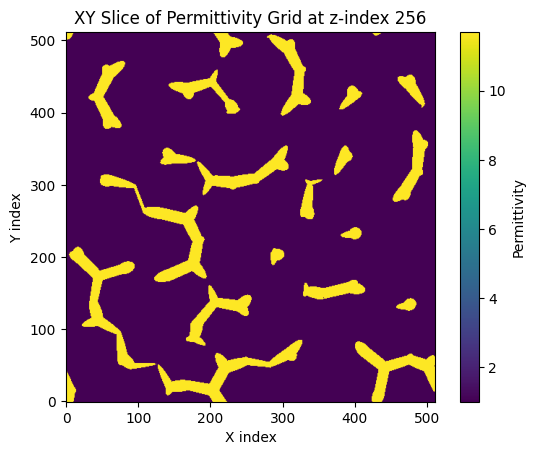

Generated a 3D permittivity grid of size (512, 512, 512) with holes.


In [56]:
# Visualize a slice of the grid
slice_index = GRID_SIZE // 2
plt.imshow(permittivity_grid[:, :, slice_index], origin='lower', cmap='viridis')
plt.colorbar(label='Permittivity')
plt.title(f'XY Slice of Permittivity Grid at z-index {slice_index}')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.show()
print("Generated a 3D permittivity grid of size ({0}, {0}, {0}) with holes.".format(GRID_SIZE))

In [57]:
# import numpy as np
# import matplotlib.pyplot as plt
# from numpy import random


# scaling = 0.27/124.16
# mean_1 = 124.16*scaling
# sigma_1 = 9.24*scaling

# # if you want multiple samples:
# samples = random.normal(loc=mean_1, scale=sigma_1, size=1000)

# # plot histogram of samples vs theoretical curve
# x_vals = np.linspace(100, 160, 1000)*scaling
# pdf = (1/(sigma_1*np.sqrt(2*np.pi))) * np.exp(-0.5*((x_vals-mean_1)/sigma_1)**2)

# plt.plot(x_vals, pdf, "r-", label="Gaussian")
# counts, bins, _ =plt.hist(samples, bins=30, density=True, alpha=0.5, label="Sample Histogram")
# plt.legend()
# plt.show()
